In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit, year, when, regexp_replace, to_timestamp ,month, minute, date_format, col, struct, from_utc_timestamp, hour

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.types import *
from IPython.display import display, clear_output
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Create Schema

In [2]:
train_data_schema = StructType([
    StructField('key', IntegerType()),
    StructField('fare_amount', FloatType()),
    StructField('pickup_datetime', StringType()),
    StructField('pickup_longitude', FloatType()),
    StructField('pickup_latitude', FloatType()),
    StructField('dropoff_longitude', FloatType()),
    StructField('dropoff_latitude', FloatType()),
    StructField('passenger_count', IntegerType())
])

test_data_schema = StructType([
    StructField('key', IntegerType()),
    StructField('pickup_datetime', StringType()),
    StructField('pickup_longitude', FloatType()),
    StructField('pickup_latitude', FloatType()),
    StructField('dropoff_longitude', FloatType()),
    StructField('dropoff_latitude', FloatType()),
    StructField('passenger_count', IntegerType())
])

In [3]:
APPLICATION_NAME    = 'final project'
TRAIN_FILE_LOCATION = 'idc_train.csv'
TEST_FILE_LOCATION  = 'idc_test.csv'

# Create Spark Session

In [4]:
spark = SparkSession.builder\
            .appName(APPLICATION_NAME)\
            .getOrCreate()

# Read Train Data File

In [5]:
spark_train_df = spark.read\
                .schema(train_data_schema)\
                .option('header', True)\
                .option('mode', 'DROPMALFORMED')\
                .csv(TRAIN_FILE_LOCATION)\
                .limit(100000)# dev

# Read Test Data File

In [6]:
spark_test_df = spark.read\
                .schema(test_data_schema)\
                .option('header', True)\
                .option('mode', 'DROPMALFORMED')\
                .csv(TEST_FILE_LOCATION)

# Data Exploration

### Train Data Set

In [7]:
spark_train_df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [8]:
spark_train_df.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------
 key               | 1                       
 fare_amount       | 8.5                     
 pickup_datetime   | 2010-03-30 19:27:00 UTC 
 pickup_longitude  | -73.96539               
 pickup_latitude   | 40.768574               
 dropoff_longitude | -73.998184              
 dropoff_latitude  | 40.761074               
 passenger_count   | 1                       
-RECORD 1------------------------------------
 key               | 2                       
 fare_amount       | 35.47                   
 pickup_datetime   | 2010-08-10 20:02:03 UTC 
 pickup_longitude  | -73.967354              
 pickup_latitude   | 40.769295               
 dropoff_longitude | -73.967285              
 dropoff_latitude  | 40.802975               
 passenger_count   | 1                       
only showing top 2 rows



In [9]:
%%time
spark_train_df.describe().show(truncate=False, vertical=True)

-RECORD 0------------------------------------
 summary           | count                   
 key               | 100000                  
 fare_amount       | 100000                  
 pickup_datetime   | 100000                  
 pickup_longitude  | 100000                  
 pickup_latitude   | 100000                  
 dropoff_longitude | 100000                  
 dropoff_latitude  | 100000                  
 passenger_count   | 100000                  
-RECORD 1------------------------------------
 summary           | mean                    
 key               | 50000.5                 
 fare_amount       | 11.261482021691986      
 pickup_datetime   | null                    
 pickup_longitude  | -72.57365245520968      
 pickup_latitude   | 39.885665285656025      
 dropoff_longitude | -72.51992902850193      
 dropoff_latitude  | 39.877450559737724      
 passenger_count   | 1.68016                 
-RECORD 2------------------------------------
 summary           | stddev       

### Test Data Set

In [10]:
spark_test_df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [11]:
spark_test_df.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------
 key               | 19990001                
 pickup_datetime   | 2012-05-31 07:04:14 UTC 
 pickup_longitude  | -73.94636               
 pickup_latitude   | 40.792088               
 dropoff_longitude | -73.96618               
 dropoff_latitude  | 40.764984               
 passenger_count   | 2                       
-RECORD 1------------------------------------
 key               | 19990002                
 pickup_datetime   | 2015-01-27 20:51:29 UTC 
 pickup_longitude  | -73.97137               
 pickup_latitude   | 40.7604                 
 dropoff_longitude | -73.995346              
 dropoff_latitude  | 40.744392               
 passenger_count   | 6                       
only showing top 2 rows



In [12]:
spark_test_df.describe().show(truncate=False, vertical=True)

-RECORD 0------------------------------------
 summary           | count                   
 key               | 10000                   
 pickup_datetime   | 10000                   
 pickup_longitude  | 10000                   
 pickup_latitude   | 10000                   
 dropoff_longitude | 10000                   
 dropoff_latitude  | 10000                   
 passenger_count   | 10000                   
-RECORD 1------------------------------------
 summary           | mean                    
 key               | 1.99950005E7            
 pickup_datetime   | null                    
 pickup_longitude  | -72.40716881915927      
 pickup_latitude   | 39.877633166885374      
 dropoff_longitude | -72.4193482875824       
 dropoff_latitude  | 39.87454365310669       
 passenger_count   | 1.6905                  
-RECORD 2------------------------------------
 summary           | stddev                  
 key               | 2886.8956799071675      
 pickup_datetime   | null         

# Data Cleaning

replace 'passenger_count' missing values by median.

In [13]:
imputer = Imputer(inputCols=['passenger_count'], outputCols=['passenger_count'])

# fit on train
imputer = imputer.setStrategy('median')\
                 .setMissingValue(0)\
                 .fit(spark_train_df)\

#transform train 
spark_train_df = imputer.transform(spark_train_df)

#transform test
spark_test_df = imputer.transform(spark_test_df)

drop rows with null values

In [14]:
spark_train_df = spark_train_df.dropna(how='any')

### Drop outliers

### 'passenger_count' column

In [15]:
spark_train_df = spark_train_df.filter( (col('passenger_count') < 15) & (col('passenger_count') > 0))

### 'fare_amount' column

In [16]:
####spark_train_df = spark_train_df.filter( (col('fare_amount') > 0) & (col('fare_amount') < 100))

### Longitude and Latitude columns

 The latitude must be a number between -90 and 90 and the longitude between -180 and 180.<br>
 we limit the coordinates to NYC area -80< longitude < -70 and 40 < latitude < 50

In [17]:
spark_train_df = spark_train_df.filter( (col('pickup_longitude') > -80) &\
                (col('pickup_longitude')             < -70) &\
                (col('pickup_latitude')              >  40) &\
                (col('pickup_latitude')              <  50) &\
                (col('dropoff_longitude')            > -80) &\
                (col('dropoff_longitude')            < -70) &\
                (col('dropoff_latitude')             >  40) &\
                (col('dropoff_latitude')             <  50) )

# Feature Engineering

### Create Local Datetime Feature

In [18]:
def to_ny_local_time(utc_timestamp):
    from datetime import datetime
    from dateutil import tz
    t_format = '%Y-%m-%d %H:%M:%S'
    from_zone = tz.gettz('UTC')
    to_zone   = tz.gettz('America/New_York')
    utc = datetime.strptime(utc_timestamp, t_format)
    utc = utc.replace(tzinfo=from_zone)
    central = utc.astimezone(to_zone)
    return central.strftime(t_format)

In [19]:
# convert 'pickup_datetime' from string to timestamp and conver from UTC to US/NY local time
udf_to_ny_local_time = udf(to_ny_local_time, StringType())

def create_local_datetime_features(df):
    return df.withColumn('pickup_datetime', regexp_replace(col('pickup_datetime'),' UTC',''))\
            .withColumn('local_pickup_datetime', udf_to_ny_local_time(col('pickup_datetime')))\
            .withColumn('local_pickup_datetime',to_timestamp('local_pickup_datetime', 'yyyy-MM-dd HH:mm:ss'))

In [20]:
spark_train_df = create_local_datetime_features(spark_train_df)
spark_test_df  = create_local_datetime_features(spark_test_df)

### Create Time Features (year, day_of_week, hour, munute)

In [21]:
def create_datetime_features(df):
    # EMR 'change local_pickup_datetime', 'e' TO 'local_pickup_datetime', 'u' spark version issue
    df = df.withColumn('day_of_week_num', date_format('local_pickup_datetime', 'e'))\
                   .withColumn('day_of_week_string', date_format('local_pickup_datetime', 'EEE'))
    df = df.withColumn('day_of_week_num', df['day_of_week_num'].cast(IntegerType()))
    return df.withColumn('pickup_month', month('local_pickup_datetime'))\
                .withColumn('pickup_hour', hour('local_pickup_datetime'))\
                .withColumn('pickup_minute', minute('local_pickup_datetime'))\
                .withColumn('pickup_year', year('local_pickup_datetime'))

In [22]:
spark_train_df = create_datetime_features(spark_train_df)
spark_test_df  = create_datetime_features(spark_test_df)

In [23]:
# for test
spark_train_df.select('pickup_datetime', 'day_of_week_num',\
                      'pickup_hour','day_of_week_string','pickup_year','pickup_month', 'pickup_minute' ).show(5)

+-------------------+---------------+-----------+------------------+-----------+------------+-------------+
|    pickup_datetime|day_of_week_num|pickup_hour|day_of_week_string|pickup_year|pickup_month|pickup_minute|
+-------------------+---------------+-----------+------------------+-----------+------------+-------------+
|2010-03-30 19:27:00|              3|         15|               Tue|       2010|           3|           27|
|2010-08-10 20:02:03|              3|         16|               Tue|       2010|           8|            2|
|2011-03-13 13:24:00|              1|          9|               Sun|       2011|           3|           24|
|2011-06-11 19:45:14|              7|         15|               Sat|       2011|           6|           45|
|2011-12-03 13:16:02|              7|          8|               Sat|       2011|          12|           16|
+-------------------+---------------+-----------+------------------+-----------+------------+-------------+
only showing top 5 rows



### Create Distance Features (manhatten, euclidean)

In [24]:
# the distance is in lon lat units
def manhattan_distance(s):
    longit_a = s[0]
    latit_a  = s[1]
    longit_b = s[2]
    latit_b  = s[3]
    return abs(longit_a-longit_b)+abs(latit_a-latit_b)

In [25]:
def abs_distance(s):
    longit_a = s[0]
    latit_a  = s[1]
    longit_b = s[2]
    latit_b  = s[3]
    # Transform to radians
    longit_a, latit_a, longit_b, latit_b = map(radians, [longit_a, latit_a, longit_b, latit_b])
    dist_longit = longit_b - longit_a
    dist_latit = latit_b - latit_a
    # Calculate area
    area = sin(dist_latit/2)**2 + cos(latit_a) * cos(latit_b) * sin(dist_longit/2)**2
    # Calculate the central angle
    central_angle = 2 * asin(sqrt(area))
    # in kilometers
    earth_radius = 6371
    # Calculate Distance
    distance = central_angle * earth_radius
    return abs(round(distance, 2))

In [26]:
udf_abs_distance = udf(abs_distance, FloatType())
udf_manhattan_distance = udf(manhattan_distance, FloatType())

def create_distance_features(df):
    return df.withColumn('abs_distance', udf_abs_distance(
                        struct('pickup_longitude',
                        'pickup_latitude',
                        'dropoff_longitude',
                        'dropoff_latitude')))\
                    .withColumn('manhattan_distance', udf_manhattan_distance(
                        struct('pickup_longitude',
                        'pickup_latitude',
                        'dropoff_longitude',
                        'dropoff_latitude')))

In [27]:
spark_train_df = create_distance_features(spark_train_df)
spark_test_df  = create_distance_features(spark_test_df)

In [28]:
# for test
spark_train_df.select('pickup_longitude', 'pickup_latitude', 'dropoff_longitude',\
                'dropoff_latitude','abs_distance','manhattan_distance').show(5)

+----------------+---------------+-----------------+----------------+------------+------------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|abs_distance|manhattan_distance|
+----------------+---------------+-----------------+----------------+------------+------------------+
|       -73.96539|      40.768574|       -73.998184|       40.761074|        2.88|       0.040290833|
|      -73.967354|      40.769295|       -73.967285|       40.802975|        3.75|       0.033748627|
|       -73.96884|      40.758278|       -73.961395|       40.768566|         1.3|       0.017734528|
|       -73.98218|      40.774796|        -73.95431|        40.78315|        2.52|       0.036224365|
|        -73.9778|       40.74228|       -73.998634|       40.734917|        1.94|       0.028198242|
+----------------+---------------+-----------------+----------------+------------+------------------+
only showing top 5 rows



### Filter zero distance trips

In [30]:
spark_train_df = spark_train_df.filter( (col('abs_distance') > 0) & (col('abs_distance') < 100) )

### Create Is Rush Hour Feature
5 to 10 a.m. and 4 to 8 p.m.

In [31]:
def is_rush_hour(pickup_hour, day):
    if ((5 <= pickup_hour <= 10) | (16 <= pickup_hour <= 20)) & ((day != 7) & (day !=1)):
        return 1
    return 0

### Hour bin feature - 24 -> 04 -> 06 -> 10 -> 16 -> 23 -> 24 

In [32]:
def hour_bin(pickup_hour):
    if pickup_hour <=4:
        return 1
    elif pickup_hour<=6:
        return 2
    elif pickup_hour<=10:
        return 3
    elif pickup_hour<=16:
        return 4
    elif pickup_hour<=19:
        return 5
    elif pickup_hour<=21:
        return 6
    elif pickup_hour<=23:
        return 7
    else:
        return 1

In [33]:
udf_rush_hour = udf(is_rush_hour, IntegerType())
udf_hour_bin = udf(hour_bin, IntegerType())

def create_is_rh_feature(df):
    return df.withColumn('rush_hour',udf_rush_hour('pickup_hour','day_of_week_num'))\
             .withColumn('hour_bin', udf_hour_bin('pickup_hour'))

In [34]:
spark_train_df = create_is_rh_feature(spark_train_df)
spark_test_df  = create_is_rh_feature(spark_test_df)

In [35]:
# for test
spark_train_df.select('local_pickup_datetime','day_of_week_num', 'rush_hour','hour_bin').show(10)

+---------------------+---------------+---------+--------+
|local_pickup_datetime|day_of_week_num|rush_hour|hour_bin|
+---------------------+---------------+---------+--------+
|  2010-03-30 15:27:00|              3|        0|       4|
|  2010-08-10 16:02:03|              3|        1|       4|
|  2011-03-13 09:24:00|              1|        0|       3|
|  2011-06-11 15:45:14|              7|        0|       4|
|  2011-12-03 08:16:02|              7|        0|       3|
|  2013-03-29 10:35:36|              6|        1|       3|
|  2013-04-21 18:33:38|              1|        0|       5|
|  2010-07-14 11:30:42|              4|        0|       4|
|  2010-12-28 18:06:05|              3|        1|       5|
|  2011-06-17 16:49:00|              6|        1|       4|
+---------------------+---------------+---------+--------+
only showing top 10 rows



### Cut lat/lon decimal numbers so we can have areas and convert it to Int

In [36]:
def round_lat_lon(value, num_of_decimal_points):
    mul = 10 
    x = num_of_decimal_points - 1
    value = str(value)
    point_index = value.index('.')
    number = int(value[0:point_index]) 
    
    
    decinal_val = value[point_index+1: point_index+1 + num_of_decimal_points]
    x = min(len(decinal_val)-1, x)
    while x > 0:
        mul = mul * 10
        x -= 1
    
    number = number * mul
    if len(decinal_val) > 0:
        number += int(decinal_val)
        
    return number
    
round_lat_lon_udf = udf(round_lat_lon, IntegerType())

In [37]:
for i in range(1, 4):
    spark_train_df = spark_train_df.withColumn("pickup_latitude_{}".format(i), round_lat_lon_udf(col("pickup_latitude"),
                                                                                                 lit(i)))
    spark_train_df = spark_train_df.withColumn("pickup_longitude_{}".format(i), round_lat_lon_udf(col("pickup_longitude"), lit(i)))
    
    
    spark_train_df = spark_train_df.withColumn("dropoff_latitude_{}".format(i), round_lat_lon_udf(col("dropoff_latitude"), lit(i)))
    spark_train_df = spark_train_df.withColumn("dropoff_longitud_{}".format(i), round_lat_lon_udf(col("dropoff_longitude"), lit(i)))
    
    
    spark_test_df = spark_test_df.withColumn("pickup_latitude_{}".format(i), round_lat_lon_udf(col("pickup_latitude"), lit(i)))
    spark_test_df = spark_test_df.withColumn("pickup_longitude_{}".format(i), round_lat_lon_udf(col("pickup_longitude"), lit(i)))
    
    
    spark_test_df = spark_test_df.withColumn("dropoff_latitude_{}".format(i), round_lat_lon_udf(col("dropoff_latitude"), lit(i)))
    spark_test_df = spark_test_df.withColumn("dropoff_longitud_{}".format(i), round_lat_lon_udf(col("dropoff_longitude"), lit(i)))

### Create High Fare Feature [0,1]

In [38]:
spark_train_df = spark_train_df.withColumn("high_fare", when(col("fare_amount") >= 10, 1).otherwise(0))

# Drop Unnecessary Columns

In [39]:
columns_to_drop = ['pickup_longitude','pickup_latitude',\
                   'dropoff_longitude', 'dropoff_latitude','day_of_week_string',\
                   'pickup_datetime','local_pickup_datetime']
spark_train_final_df = spark_train_df.drop(*columns_to_drop)
spark_test_final_df  = spark_test_df.drop(*columns_to_drop)

# Final Train Data Set

In [40]:
spark_train_final_df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- day_of_week_num: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- abs_distance: float (nullable = true)
 |-- manhattan_distance: float (nullable = true)
 |-- rush_hour: integer (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- pickup_latitude_1: integer (nullable = true)
 |-- pickup_longitude_1: integer (nullable = true)
 |-- dropoff_latitude_1: integer (nullable = true)
 |-- dropoff_longitud_1: integer (nullable = true)
 |-- pickup_latitude_2: integer (nullable = true)
 |-- pickup_longitude_2: integer (nullable = true)
 |-- dropoff_latitude_2: integer (nullable = true)
 |-- dropoff_longitud_2: integer (nullable = true)
 |-- pickup_latitude_3: integer (nullable = true)
 |-- pickup

In [41]:
%%time
spark_train_final_df.describe().show(truncate=False, vertical=True)

-RECORD 0----------------------------------
 summary            | count                
 key                | 96676                
 fare_amount        | 96676                
 passenger_count    | 96676                
 day_of_week_num    | 96676                
 pickup_month       | 96676                
 pickup_hour        | 96676                
 pickup_minute      | 96676                
 pickup_year        | 96676                
 abs_distance       | 96676                
 manhattan_distance | 96676                
 rush_hour          | 96676                
 hour_bin           | 96676                
 pickup_latitude_1  | 96676                
 pickup_longitude_1 | 96676                
 dropoff_latitude_1 | 96676                
 dropoff_longitud_1 | 96676                
 pickup_latitude_2  | 96676                
 pickup_longitude_2 | 96676                
 dropoff_latitude_2 | 96676                
 dropoff_longitud_2 | 96676                
 pickup_latitude_3  | 96676     

# Final Test Data Set

In [42]:
spark_test_final_df.printSchema()

root
 |-- key: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- day_of_week_num: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- abs_distance: float (nullable = true)
 |-- manhattan_distance: float (nullable = true)
 |-- rush_hour: integer (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- pickup_latitude_1: integer (nullable = true)
 |-- pickup_longitude_1: integer (nullable = true)
 |-- dropoff_latitude_1: integer (nullable = true)
 |-- dropoff_longitud_1: integer (nullable = true)
 |-- pickup_latitude_2: integer (nullable = true)
 |-- pickup_longitude_2: integer (nullable = true)
 |-- dropoff_latitude_2: integer (nullable = true)
 |-- dropoff_longitud_2: integer (nullable = true)
 |-- pickup_latitude_3: integer (nullable = true)
 |-- pickup_longitude_3: integer (nullable = true)
 |

In [43]:
%%time
spark_test_final_df.describe().show(truncate=False, vertical=True)

-RECORD 0---------------------------------
 summary            | count               
 key                | 10000               
 passenger_count    | 10000               
 day_of_week_num    | 10000               
 pickup_month       | 10000               
 pickup_hour        | 10000               
 pickup_minute      | 10000               
 pickup_year        | 10000               
 abs_distance       | 10000               
 manhattan_distance | 10000               
 rush_hour          | 10000               
 hour_bin           | 10000               
 pickup_latitude_1  | 10000               
 pickup_longitude_1 | 10000               
 dropoff_latitude_1 | 10000               
 dropoff_longitud_1 | 10000               
 pickup_latitude_2  | 10000               
 pickup_longitude_2 | 10000               
 dropoff_latitude_2 | 10000               
 dropoff_longitud_2 | 10000               
 pickup_latitude_3  | 10000               
 pickup_longitude_3 | 10000               
 dropoff_la

# Final Dataset

column|type|values|description
-|-|-|-
fare_amount|float|0-500|the cost of the ride
passenger_count|int|1-15|number of passengers
day_of_week_num|int|1-7|1=san,...,7-sat
abs_distance|float|>0|distance in km
pickup_hour|int|0-23|
pickup_minute|int|0-60
pickup_year|int|
high_fare|int|0-1|value=0 if fare_amount<10 else value=1
manhattan_distance|float|>0|in lon lat units
pickup_month|int|0-12
rush_hour|int|0-1|5 to 10 a.m. and 4 to 8 p.m, monday to friday
hour_bin|int|1-7|hour bin - 24 -> 04 -> 06 -> 10 -> 16 -> 23 -> 24
pickup_latitude_[1-3]|int||pickup latitude area
pickup_longitude_[1-3]|int||pickup longitude area
dropoff_latitude_[1-3]|int||dropoff latitude area
dropoff_longitud_[1-3]|int||dropoff longitud area

# Pearson Correlation Between Fare Amount And Distance

linear relationship between 'fare_amount' and 'abs_distance'

In [44]:
%%time
spark_train_final_df.stat.corr('fare_amount','abs_distance')

CPU times: user 1.12 ms, sys: 2.59 ms, total: 3.71 ms
Wall time: 3.67 s


0.8419367995805621

In [45]:
%%time
spark_train_final_df.stat.corr('fare_amount','manhattan_distance')

CPU times: user 1.16 ms, sys: 1.39 ms, total: 2.55 ms
Wall time: 3.59 s


0.8319969050781874

# Aggregations

The purpose is to avoid doing heavy computation with pandas, and use the results for the visualization part.

In [71]:
%%time
avg_distance_and_fare_per_hour = spark_train_final_df.groupBy('pickup_hour')\
                                               .agg({'abs_distance':'avg', 'fare_amount':'avg'})

CPU times: user 1.97 ms, sys: 1.42 ms, total: 3.39 ms
Wall time: 14.7 ms


In [72]:
%%time
avg_distance_and_fare_per_day = spark_train_final_df.groupBy('day_of_week_num')\
                                              .agg({'abs_distance':'avg', 'fare_amount':'avg'})

CPU times: user 1.76 ms, sys: 1.31 ms, total: 3.06 ms
Wall time: 10.6 ms


In [73]:
%%time
avg_distance_and_fare_per_month = spark_train_final_df.groupBy('pickup_month')\
                                              .agg({'abs_distance':'avg', 'fare_amount':'avg'})

CPU times: user 2.23 ms, sys: 1.33 ms, total: 3.55 ms
Wall time: 15.7 ms


In [74]:
%%time
avg_distance_and_fare_per_year = spark_train_final_df.groupBy('pickup_year')\
                                              .agg({'abs_distance':'avg', 'fare_amount':'avg'})

CPU times: user 1.97 ms, sys: 1.44 ms, total: 3.41 ms
Wall time: 11.2 ms


# Data Visualization

In [56]:
percent_from_spark_train_final_df = 0.8

In [57]:
%%time
pandas_df = spark_train_final_df.sample(False, percent_from_spark_train_final_df, 42).toPandas()

CPU times: user 721 ms, sys: 136 ms, total: 857 ms
Wall time: 1min 38s


### Fare Amount Distribution

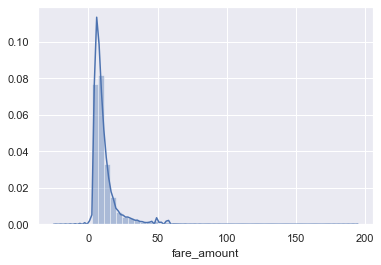

In [58]:
sns.distplot(pandas_df['fare_amount']);

### Distance Distribution

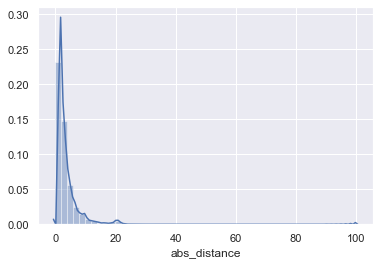

In [59]:
sns.distplot(pandas_df['abs_distance']);

### Ride Fare VS Ride Length 

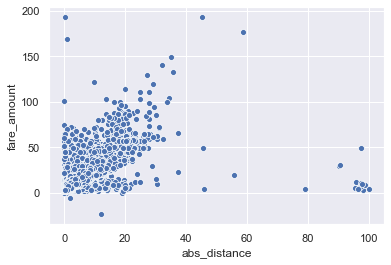

In [60]:
sns.scatterplot(x='abs_distance',y='fare_amount', data=pandas_df);

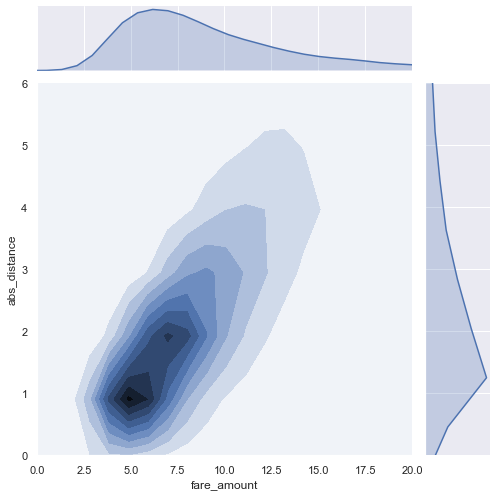

In [61]:
sns.jointplot('fare_amount','abs_distance', data=pandas_df.sample(n=5000, random_state=1),
                  kind='kde', truncate=False,
                  xlim=(0, 20), ylim=(0, 6),
                  color='b', height=7);

## Linear  VS Monotonic Relationship Between Features

In [62]:
s_corr = pandas_df.corr(method='spearman')
p_corr = pandas_df.corr(method='pearson')

## Spearman Correlation

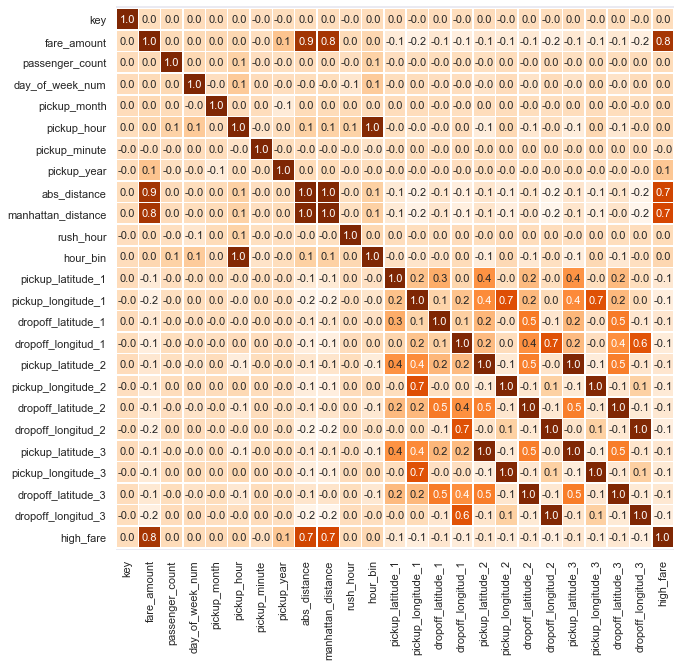

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(25.1, -0.1)
ax = sns.heatmap(s_corr, annot=True, annot_kws={"size": 11}, linewidths=0.5,
                    cbar=False, linecolor='w', cmap="Oranges", fmt='.1f')
ax.set_ylim(25.1, -0.1);

## Pearson Correlation

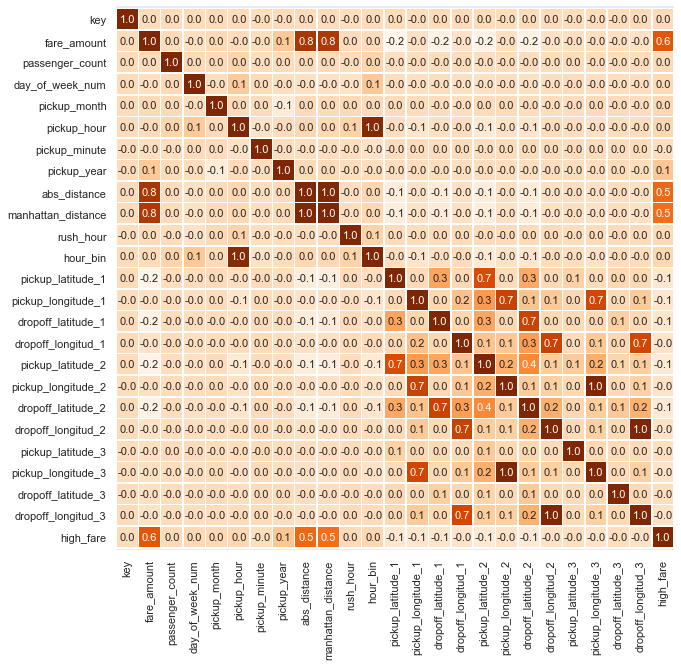

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(p_corr, annot=True, annot_kws={"size": 11}, linewidths=0.5,
                    cbar=False, linecolor='w', cmap="Oranges", fmt='.1f')
ax.set_ylim(25.1, -0.1);

### Average abs_distance and fare_amount per pickup_hour

In [76]:
%%time
p2_df = avg_distance_and_fare_per_hour.toPandas()

CPU times: user 17.4 ms, sys: 9.03 ms, total: 26.5 ms
Wall time: 17.3 s


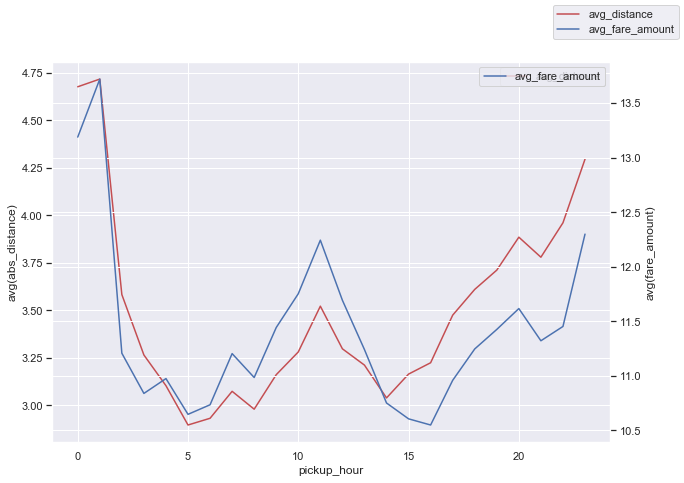

In [77]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='pickup_hour',y='avg(abs_distance)',ax=ax, data=p2_df, color='r', label='avg_distance')
ax2 = ax.twinx()
sns.lineplot(x='pickup_hour',y='avg(fare_amount)',ax=ax2, data=p2_df, label='avg_fare_amount')
ax.figure.legend();

### Average abs_distance and fare_amount per pickup_day

In [78]:
%%time
p3_df = avg_distance_and_fare_per_day.toPandas()

CPU times: user 15.1 ms, sys: 7.4 ms, total: 22.5 ms
Wall time: 14.1 s


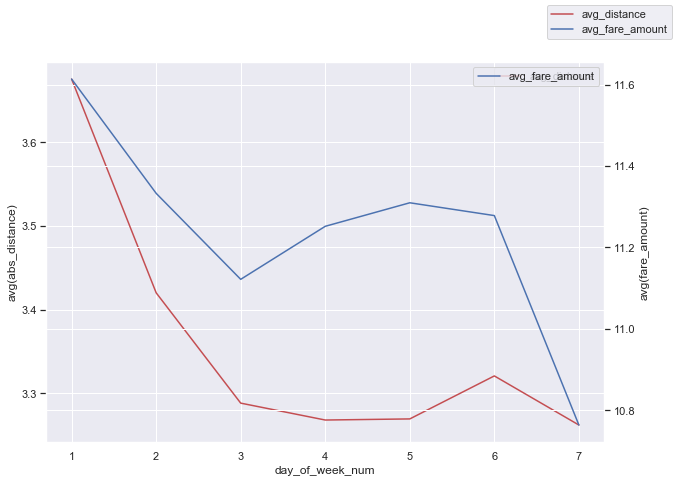

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='day_of_week_num',y='avg(abs_distance)',ax=ax, data=p3_df, color='r', label='avg_distance')
ax2 = ax.twinx()
sns.lineplot(x='day_of_week_num',y='avg(fare_amount)',ax=ax2, data=p3_df, label='avg_fare_amount')
ax.figure.legend();

### Average abs_distance and fare_amount per pickup_month

In [80]:
%%time
p4_df = avg_distance_and_fare_per_month.toPandas()

CPU times: user 15.3 ms, sys: 8.49 ms, total: 23.8 ms
Wall time: 13.8 s


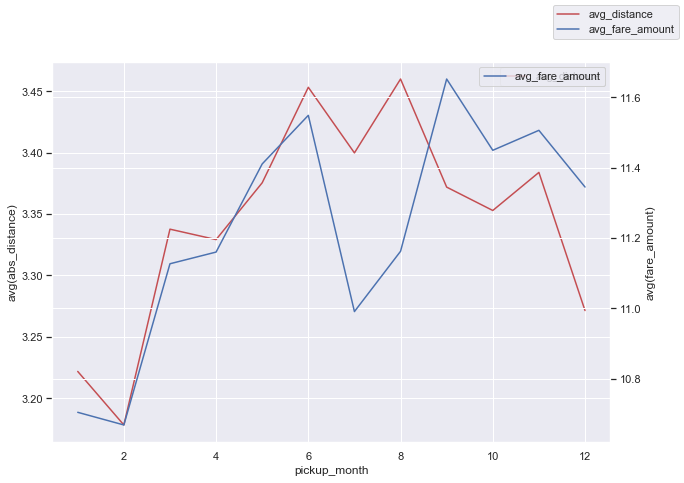

In [81]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='pickup_month',y='avg(abs_distance)',ax=ax, data=p4_df, color='r', label='avg_distance')
ax2 = ax.twinx()
sns.lineplot(x='pickup_month',y='avg(fare_amount)',ax=ax2, data=p4_df, label='avg_fare_amount')
ax.figure.legend();

### Average abs_distance and fare_amount per pickup_year

In [82]:
%%time
p5_df = avg_distance_and_fare_per_year.toPandas()

CPU times: user 16 ms, sys: 7.99 ms, total: 24 ms
Wall time: 15 s


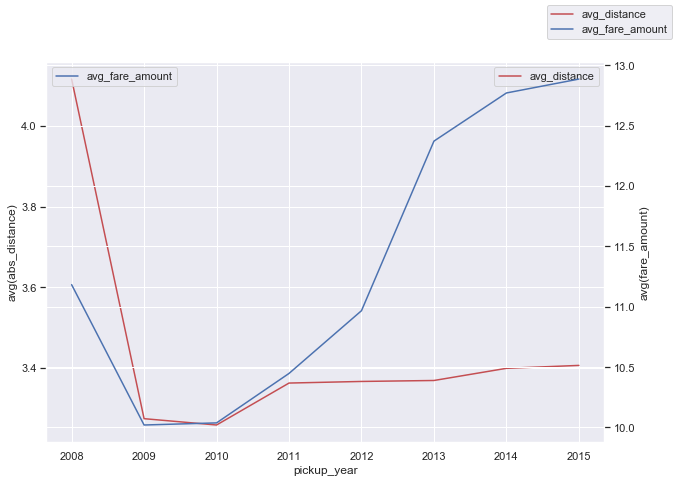

In [83]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='pickup_year',y='avg(abs_distance)',ax=ax, data=p5_df, color='r', label='avg_distance')
ax2 = ax.twinx()
sns.lineplot(x='pickup_year',y='avg(fare_amount)',ax=ax2, data=p5_df, label='avg_fare_amount')
ax.figure.legend();

# Modeling

In [84]:
spark_train_final_df = spark_train_final_df.drop('fare_amount').drop('key')

In [85]:
spark_train_final_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- day_of_week_num: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- abs_distance: float (nullable = true)
 |-- manhattan_distance: float (nullable = true)
 |-- rush_hour: integer (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- pickup_latitude_1: integer (nullable = true)
 |-- pickup_longitude_1: integer (nullable = true)
 |-- dropoff_latitude_1: integer (nullable = true)
 |-- dropoff_longitud_1: integer (nullable = true)
 |-- pickup_latitude_2: integer (nullable = true)
 |-- pickup_longitude_2: integer (nullable = true)
 |-- dropoff_latitude_2: integer (nullable = true)
 |-- dropoff_longitud_2: integer (nullable = true)
 |-- pickup_latitude_3: integer (nullable = true)
 |-- pickup_longitude_3: integer (nullable = true)
 |-- dropoff_latitude_3: integer (null

### Cast all the features to float

In [86]:
features_list = spark_train_final_df.columns[:]
for feature in features_list:
    spark_train_final_df = spark_train_final_df.withColumn(feature, spark_train_final_df[feature].cast(FloatType()))
    
features_list = spark_test_final_df.columns[:]
for feature in features_list:
    spark_test_final_df = spark_test_final_df.withColumn(feature, spark_test_final_df[feature].cast(FloatType()))

### Vectorize features

In [87]:
columns_to_vectorize = ['passenger_count', 'day_of_week_num', 'pickup_month', 'pickup_hour',
                        'pickup_minute',
                        'pickup_year',
                        'abs_distance', 'manhattan_distance',
                        'rush_hour', 'hour_bin',
                        'pickup_latitude_1',
                        'pickup_longitude_1',
                        'dropoff_longitud_1', 
                        'dropoff_latitude_1', 
                        
                        'pickup_latitude_2',
                        'pickup_longitude_2',
                        'dropoff_longitud_2', 
                        'dropoff_latitude_2', 
                        
                        'pickup_latitude_3',
                        'pickup_longitude_3',
                         
                        'dropoff_longitud_3',
                        'dropoff_latitude_3'
                        ]

In [88]:
def vectorize_features(df, columns):
    assembler = VectorAssembler(inputCols=columns, outputCol='features')
    
    data = assembler.transform(df)
    return data

In [89]:
train_data = vectorize_features(spark_train_final_df, columns_to_vectorize)
test_data = vectorize_features(spark_test_final_df, columns_to_vectorize)

In [90]:
test_data.cache()
train_data.cache()

DataFrame[passenger_count: float, day_of_week_num: float, pickup_month: float, pickup_hour: float, pickup_minute: float, pickup_year: float, abs_distance: float, manhattan_distance: float, rush_hour: float, hour_bin: float, pickup_latitude_1: float, pickup_longitude_1: float, dropoff_latitude_1: float, dropoff_longitud_1: float, pickup_latitude_2: float, pickup_longitude_2: float, dropoff_latitude_2: float, dropoff_longitud_2: float, pickup_latitude_3: float, pickup_longitude_3: float, dropoff_latitude_3: float, dropoff_longitud_3: float, high_fare: float, features: vector]

### Scale features  

In [91]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True)
scaler_trans = scaler.fit(train_data)

### Fit on trainning and transform both train and test 

In [92]:
train_data = train_data.withColumn('label', col('high_fare')).drop('high_fare')

In [93]:
train, validation = train_data.randomSplit([0.8,0.2], seed=42)

In [94]:
def predict(model, data):
    predictions = model.transform(data)
    return predictions

In [95]:
def model_scores(model, model_name, score_data, dataset_name):
    print('-------------------------------------------------------------------------------')
    print('dataset_name: {}'.format(dataset_name))
    predictions = model.transform(score_data)
    predictions_pd = predictions.toPandas()
    auc = roc_auc_score(predictions_pd['label'], predictions_pd['prediction'])
    c_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])
    print(model_name)
    ax = sns.heatmap(c_matrix, annot=True, annot_kws={"size": 11}, linewidths=0.5,
                    cbar=False, linecolor='w', cmap="Oranges", fmt='.1f')
    ax.set_title('Confusion matrix')
    ax.set_ylim(1.9, -0.1)
    print('AUC: ', auc)
    print(classification_report(predictions_pd['label'], predictions_pd['prediction']))
    print('-------------------------------------------------------------------------------')

# LogisticRegression

In [96]:
def buildLR():
    lr = LogisticRegression()
    return lr

In [97]:
lr_model = buildLR()
train_data_scalled = scaler_trans.transform(train).withColumn("features", col("scaled_features")).drop("scaled_features")
validation_data_scalled = scaler_trans.transform(validation).withColumn("features", col("scaled_features")).drop("scaled_features")
test_data_scalled = scaler_trans.transform(test_data).withColumn("features", col("scaled_features")).drop("scaled_features")
        
train_start = int(time.time())
print('start train {}'.format(train_start))

lr_model = lr_model.fit(train_data_scalled)
train_end = int(time.time())     
print('end train {}'.format(train_end))
      
print('train train sec {}'.format(int(train_end - train_start)))

start train 1595169801
end train 1595169809
train train sec 8


-------------------------------------------------------------------------------
dataset_name: train
LogisticRegression
AUC:  0.8589469836932291
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     47172
         1.0       0.89      0.78      0.83     30067

    accuracy                           0.88     77239
   macro avg       0.88      0.86      0.87     77239
weighted avg       0.88      0.88      0.87     77239

-------------------------------------------------------------------------------


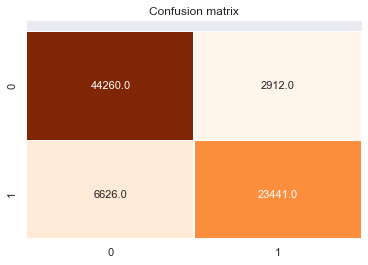

In [98]:
model_scores(lr_model, 'LogisticRegression', train_data_scalled, 'train')

-------------------------------------------------------------------------------
dataset_name: validation
LogisticRegression
AUC:  0.8549540843521491
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     11834
         1.0       0.89      0.77      0.83      7603

    accuracy                           0.87     19437
   macro avg       0.88      0.85      0.86     19437
weighted avg       0.87      0.87      0.87     19437

-------------------------------------------------------------------------------


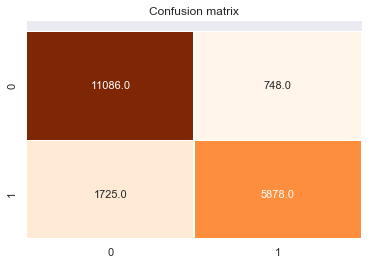

In [99]:
model_scores(lr_model, 'LogisticRegression', validation_data_scalled, 'validation')

# RandomForestClassifier

In [100]:
def buildRF():
    rf = RandomForestClassifier(seed=24, subsamplingRate=0.7, maxDepth=10)
    return rf

In [101]:
rf_model = buildRF()

train_start = int(time.time())
print('start train {}'.format(train_start))

rf_model = rf_model.fit(train)
train_end = int(time.time())     
print('end train {}'.format(train_end))
      
print('train train sec {}'.format(int(train_end - train_start)))

start train 1595169829
end train 1595169839
train train sec 10


-------------------------------------------------------------------------------
dataset_name: train
RandomForestClassifier
AUC:  0.8885243019299354
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92     47172
         1.0       0.91      0.83      0.87     30067

    accuracy                           0.90     77239
   macro avg       0.90      0.89      0.89     77239
weighted avg       0.90      0.90      0.90     77239

-------------------------------------------------------------------------------


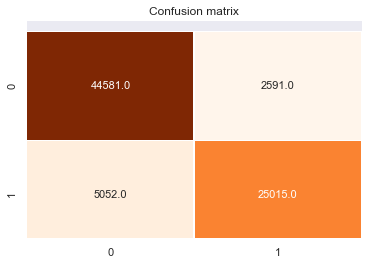

In [102]:
model_scores(rf_model, 'RandomForestClassifier', train, 'train')


-------------------------------------------------------------------------------
dataset_name: validation
RandomForestClassifier
AUC:  0.8724758208219089
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     11834
         1.0       0.89      0.81      0.85      7603

    accuracy                           0.89     19437
   macro avg       0.89      0.87      0.88     19437
weighted avg       0.89      0.89      0.89     19437

-------------------------------------------------------------------------------


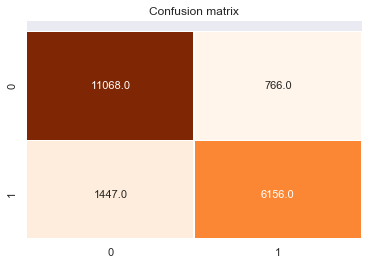

In [103]:
model_scores(rf_model, 'RandomForestClassifier', validation, 'validation')

# GBTClassifier

In [104]:
def buildXGB():
    gbt = GBTClassifier(seed=42, maxDepth=8, subsamplingRate=0.80, maxIter=250)
    return gbt

In [105]:
xgb_model = buildXGB()

train_start = int(time.time())
print('start train {}'.format(train_start))

xgb_model = xgb_model.fit(train)
train_end = int(time.time())     
print('end train {}'.format(train_end))
      
print('train train sec {}'.format(int(train_end - train_start)))

start train 1595169860
end train 1595170609
train train sec 749


-------------------------------------------------------------------------------
dataset_name: train
GBTClassifier
AUC:  0.9631162465643062
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     47172
         1.0       0.99      0.93      0.96     30067

    accuracy                           0.97     77239
   macro avg       0.97      0.96      0.97     77239
weighted avg       0.97      0.97      0.97     77239

-------------------------------------------------------------------------------


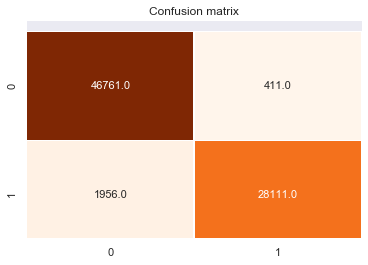

In [106]:
model_scores(xgb_model, 'GBTClassifier', train, 'train')

-------------------------------------------------------------------------------
dataset_name: validation
GBTClassifier
AUC:  0.888699958794718
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     11834
         1.0       0.90      0.84      0.87      7603

    accuracy                           0.90     19437
   macro avg       0.90      0.89      0.89     19437
weighted avg       0.90      0.90      0.90     19437

-------------------------------------------------------------------------------


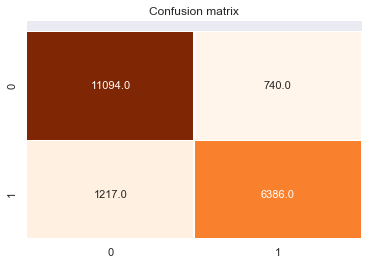

In [107]:
model_scores(xgb_model, 'GBTClassifier', validation, 'validation')

In [ ]:
def kaggle_output(model, data, f_name):
    results_df = predict(model, data)
    df = results_df.select("key", "prediction").toPandas()
    df[['key', 'high_fare']].to_csv(f_name, index=False)

In [ ]:
kaggle_output(rf_model, test_data, 'rf_kaggle.csv')

In [ ]:
kaggle_output(xgb_model, test_data, 'xg_kaggle.csv')

In [ ]:
kaggle_output(rf_model, test_data, 'lr_kaggle.csv')